<a href="https://colab.research.google.com/github/anish-neervannan/ese546_final_project/blob/main/ese546_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ESE 546 Final Project: The Effect of Genetic Algorithms on Long Short Term Memory Networks with Attention Modules**

### **Authors**
- Anish Neervannan (PennKey: anishrn)
- Vinay Senthil (PennKey: vinayksk)
- Bhaskar Abhiraman (PennKey: bhaskara)

### **Import Kaggle Dataset**

1. Use Chrome Extension "[Get cookies.txt](https://chrome.google.com/webstore/detail/get-cookiestxt/bgaddhkoddajcdgocldbbfleckgcbcid?utm_campaign=en&utm_source=en-ha-na-us-bk-ext&utm_medium=ha)" to download cookies from [here](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) after logging in.
2. Save the file as "cookies.txt" and upload it in the next cell.
3. A version of "cookies.txt" is also in the shared Drive for this project.

In [1]:
from google.colab import files

uploaded = files.upload()

Saving cookies.txt to cookies.txt


This cell imports all the data (492 MB) straight from Kaggle to the Colab workspace.

In [ ]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/download" -O data.zip
!unzip data.zip

For example, graph AAPL over time.

         Date     Open     High      Low    Close    Volume  OpenInt
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0


Text(0.5, 1.0, 'AAPL Opening Price Over Time')

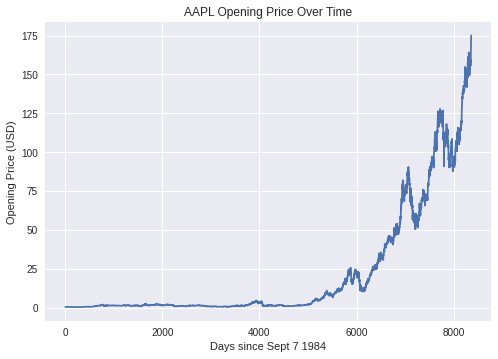

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

aapl_data = pd.read_csv("Stocks/aapl.us.txt")
print(aapl_data.head())
plt.plot(aapl_data.Open);
plt.xlabel("Days since Sept 7 1984")
plt.ylabel("Opening Price (USD)");
plt.title("AAPL Opening Price Over Time")

### **LSTM for Numerical Sequences**

### To do:


*   Plagiarize less - everything is mostly changed except: (1) get_batch to process multiple batches, (2) change LSTM() network architecture (maybe use the one from earlier homework), (3) change eval code, (4) why is test_data not scaled?
*   Validation metrics (MAE per sector)
*   Preprocess all stock data by sector/S&P
*   Implement mini-batching (looking at fixed-length sequences of various stocks)
*   Characterize base LSTM
*   Attention
*   Get S&P 500 info/sector info/stock symbols

LSTM for Numerical Sequences based on:
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/


In [4]:
# from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Preprocess the data, select the appropriate stocks and convert to numpy
# Rescale training data between -1 and 1
stock = 'aapl'
stock_pd_frame = pd.read_csv("Stocks/{}.us.txt".format(stock))
stock_np = np.asarray(stock_pd_frame.Open)

train_size = 500
test_size = 12

train_data = stock_np[-train_size-test_size:-test_size]
test_data = stock_np[-test_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [6]:
# helper method to get a training sequence starting at a particular point in the sequence
def get_batch(input_data, seq_len, i):
    train_seq = input_data[i:i+seq_len]
    train_label = input_data[i+seq_len:i+seq_len+1]
    return (train_seq ,train_label)

In [7]:
# LSTM class module defined
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [12]:
epochs = 150
seq_len = 12
print_and_save_interval = 1
num_batches = len(train_data_normalized) - seq_len

model = LSTM().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

tr_losses = np.zeros(epochs)

print(model)
#Training Loop
for epoch in range(epochs):
    for j in range(num_batches):
        # Fetch the batched data and push to GPU
        X, y = get_batch(train_data_normalized, seq_len, j)
        X = torch.Tensor(X).to(device)
        y = torch.Tensor(y).to(device)

        # Zero out the gradients and hidden cells
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        # Compute predicted value
        y_pred = model(X)

        # Compute loss and backpropagate
        loss = criterion(y_pred, torch.flatten(y))
        loss.backward()
        optimizer.step()

        # Record average loss over each epoch
        tr_losses[epoch] += loss.item()/num_batches

    # Report loss every few epochs
    if epoch % print_and_save_interval == 0:
        print ('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, epochs, tr_losses[epoch]))
        

print ('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Epoch [1/150], Training Loss: 0.0842
Epoch [2/150], Training Loss: 0.1590
Epoch [3/150], Training Loss: 0.1288
Epoch [4/150], Training Loss: 0.0912
Epoch [5/150], Training Loss: 0.0837
Epoch [6/150], Training Loss: 0.0813
Epoch [7/150], Training Loss: 0.0789
Epoch [8/150], Training Loss: 0.0768
Epoch [9/150], Training Loss: 0.0760
Epoch [10/150], Training Loss: 0.0654
Epoch [11/150], Training Loss: 0.0593
Epoch [12/150], Training Loss: 0.0570
Epoch [13/150], Training Loss: 0.0544
Epoch [14/150], Training Loss: 0.0498
Epoch [15/150], Training Loss: 0.0491
Epoch [16/150], Training Loss: 0.0460
Epoch [17/150], Training Loss: 0.0453
Epoch [18/150], Training Loss: 0.0424
Epoch [19/150], Training Loss: 0.0427
Epoch [20/150], Training Loss: 0.0406
Epoch [21/150], Training Loss: 0.0386
Epoch [22/150], Training Loss: 0.0401
Epoch [23/150], Training Loss: 0.0378
Epoch [24/150], Training Loss: 0.0367
Epo

Text(0, 0.5, 'Loss (L1 Distance)')

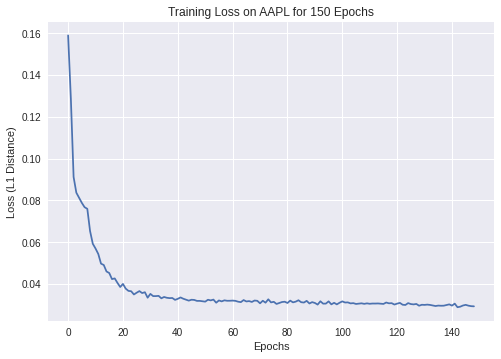

In [20]:
plt.plot(tr_losses[1:]);
plt.title('Training Loss on AAPL for 150 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (L1 Distance)')

In [21]:
num_preds = 12

test_inputs = np.ndarray.flatten(train_data_normalized[-seq_len:]).tolist()

model.eval()

for i in range(num_preds):
    seq = torch.FloatTensor(test_inputs[-seq_len:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

In [22]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[seq_len:] ).reshape(-1, 1))


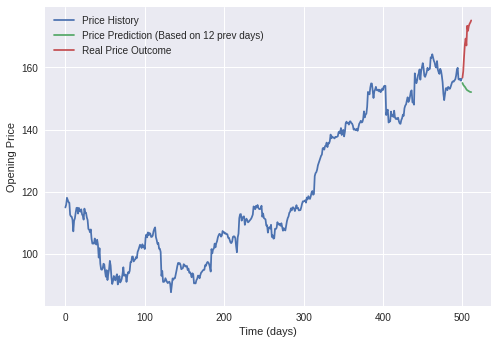

In [28]:
ts = np.arange(0,train_size + test_size,1)
plt.plot(ts[:train_size],train_data)
plt.plot(ts[-test_size:],actual_predictions)
plt.plot(ts[-test_size:],stock_np[-test_size:])
plt.xlabel('Time (days)')
plt.ylabel('Opening Price')
plt.legend(['Price History', 'Price Prediction (Based on 12 prev days)','Real Price Outcome'])